# Sensors and Actuators Lab 1: Data Analysis
In order to carry out the points described in the lab, we have to carry out some calculations and plotting, which we have chosen to do in python.

First we import necessary libraries

In [171]:
import pandas as pd # Used for data handling
import numpy as np # Used for calculations
import matplotlib.pyplot as plt # Used to create plots
pd.set_option('mode.chained_assignment', None)

Then we load the data from Excel into a dataframe

The data is split into 4 columns:
- Input Voltage
- Set (which recording it is, where 1 way is 1 set. i.e. going back and forth is 2 sets.)
- Angular Displacement, measured in degrees
- Measured Voltage, given in mV

In [172]:
df = pd.read_excel(io="../data/DataInExcel.xlsx", sheet_name="Sheet1")
df = df.rename(columns={"InputVoltage": "Input Voltage", "Displacement(deg)": "Angular Displacement", "Voltage(mv)": "Recorded Voltage (mV)"})
df

,Input Voltage,Set,Angular Displacement,Recorded Voltage (mV)
0,1,forward,0,1090.989
1,1,forward,10,1090.887
2,1,forward,20,1090.046
3,1,forward,30,1087.004
4,1,forward,40,1079.484
...,...,...,...,...
243,10,backward,40,9954.300
244,10,backward,30,10024.800
245,10,backward,20,10062.000
246,10,backward,10,10062.100


Firstly, we have to some data separation and cleaning.
All the data is split into 3 tables:
- Values from Input Voltage of 1 V
- Values from Input Voltage of 3 V
- Values from Input Voltage of 10 V

For 10 V, data was recorded going from 0 to 300 and 300 to 0, and this was done 3 times. So we will make an average of each of these, to use moving forward.

In [173]:
input_voltages = [1, 3, 10] #Getting Input Voltages as reference
sets = ["forward", "backward"]
df_v1 = df[df["Input Voltage"] == 1] # Table for Input Voltage 1V
df_v3 = df[df["Input Voltage"] == 3] # Table for Input Voltage 3V
df_v10 = df[df["Input Voltage"] == 10] # Table for Input Voltage 10V
print(df_v3)
df_v10 = df_v10.groupby(["Angular Displacement", "Set"]).mean().reset_index()

# Recreate the df_list
df_list = [df_v1, df_v3, df_v10]

    Input Voltage      Set  Angular Displacement  Recorded Voltage (mV)
31              3  forward                     0               3085.500
32              3  forward                    10               3085.700
33              3  forward                    20               3085.900
34              3  forward                    30               3075.300
35              3  forward                    40               3052.000
36              3  forward                    50               3030.000
37              3  forward                    60               3006.300
38              3  forward                    70               2982.300
39              3  forward                    80               2959.200
40              3  forward                    90               2936.900
41              3  forward                   100               2914.500
42              3  forward                   110               2892.600
43              3  forward                   120               2

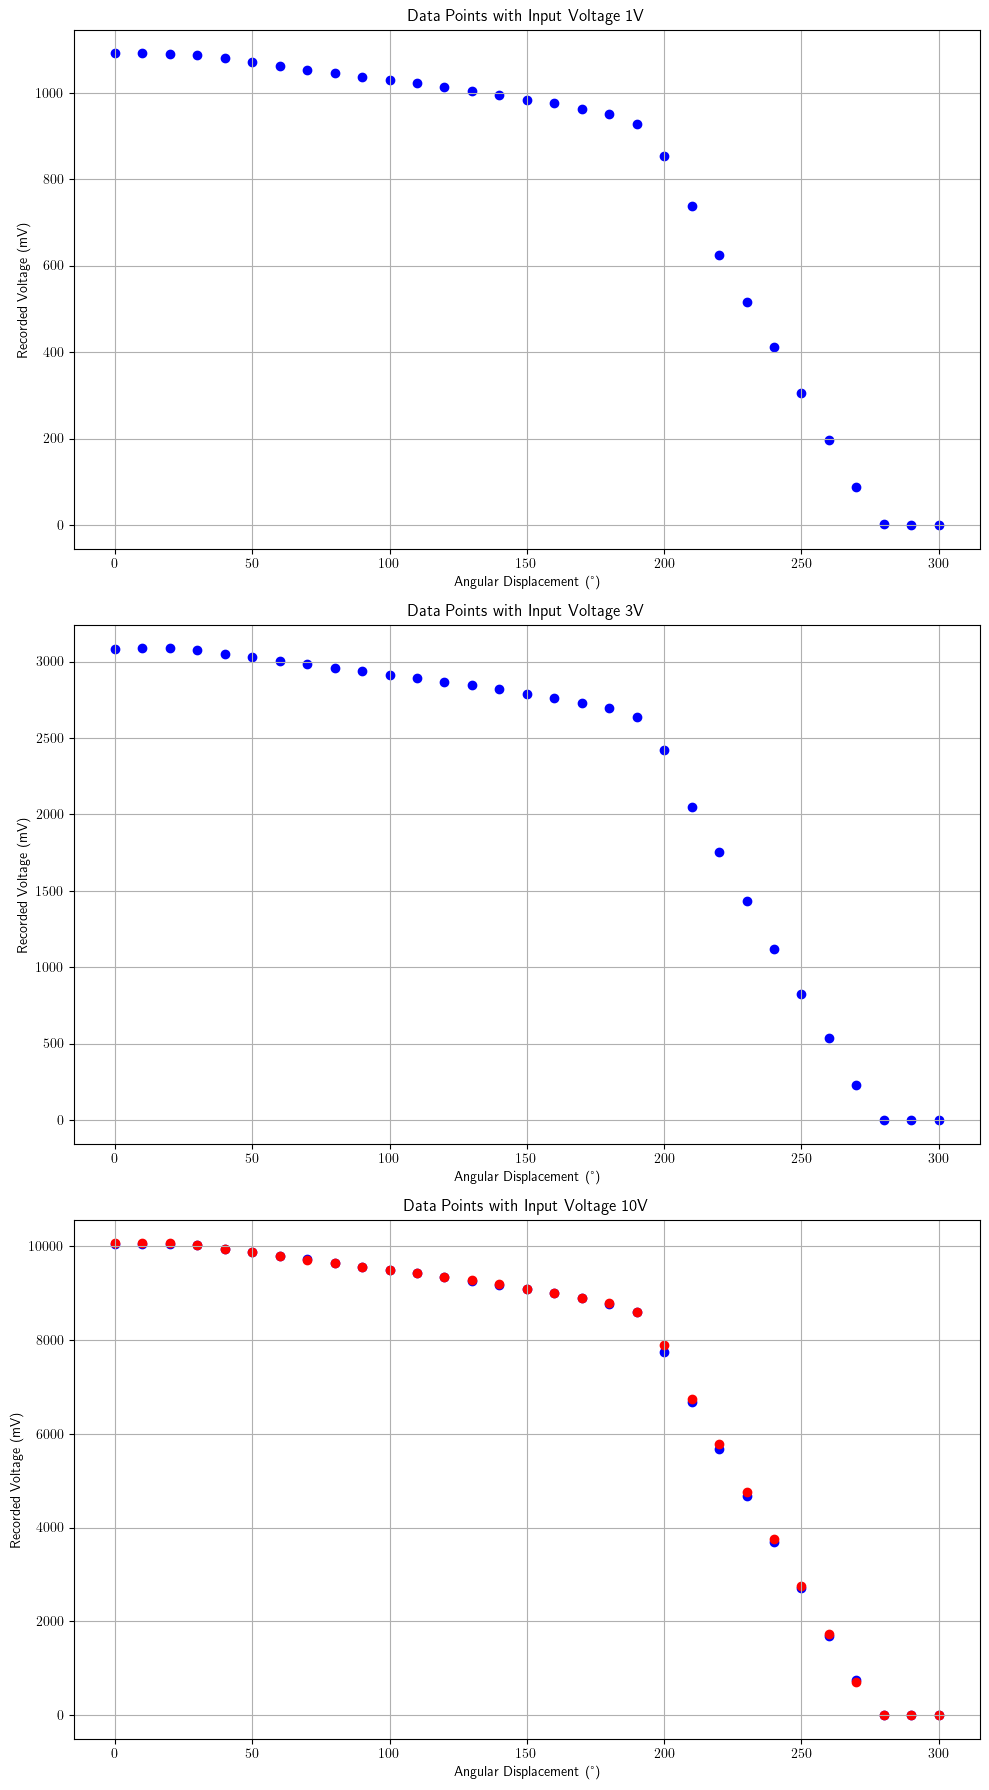

In [174]:
# Create separate plots for each DataFrame
fig, axes = plt.subplots(len(df_list), 1, figsize=(10, 6 * len(df_list)))
color_map = {
    "forward": "blue",
    "backward": "red"
}

for ax, df, volt in zip(axes, df_list, input_voltages ):
    for set_val, color in color_map.items():
        subset = df[df["Set"] == set_val]
        ax.scatter(subset["Angular Displacement"], subset["Recorded Voltage (mV)"], color=color, label=f"{volt} {set_val}")

    ax.set_title(f"Data Points with Input Voltage {volt}V")
    ax.set_xlabel("Angular Displacement (\u00B0)")
    ax.set_ylabel("Recorded Voltage (mV)")
    ax.grid(True)

plt.tight_layout()
plt.show()

After having the scatter plots, we can make the following conclusions:
**Conclusion 1:**
Between 0-20 degrees, the variation in the values is minimal, and in some cases non-existent

**Conclusion 2:**
Between 280-300 degrees, the same issue as above occur as the get a voltage in 0.XX mV, with almost no variations

**Conclusion 3:**
Between 20-190 degrees, there is a linear decline, that has a readable difference. Meaning one could use it
within this range, which would allow the potentiometer to act as an angular displacement sensor with a range of
180 degrees.

**Conclusion 4:**
Between 190-280 degrees, there is also a linear segment, that has a very readable difference, which would allow
for more noticeable change in voltage per degree, which would allow the potentiometer to act as an angular
displacement sensor with a range of 90 degrees.


## Ideal Straight Line
We now split the data up into 4 parts, where the points at 0, 10, 290, 300 degrees is left out. We will then
look at the data in 2 parts:
- 20-190 degrees
- 190-280 degrees


First 20-190 Degrees:

We can then create the sensitivity factor of the ideal straight line using the formula:
$K = \frac{O_{max}-O_{min}}{I_{max}-I_{min}}$

For the values at 10 V, the 3 recorded values from 20-180, averaged to find the ideal straight line, and there will be 2 ideal straight lines: going up in angular displacement, and going back (which will be compared later for hysteresis)

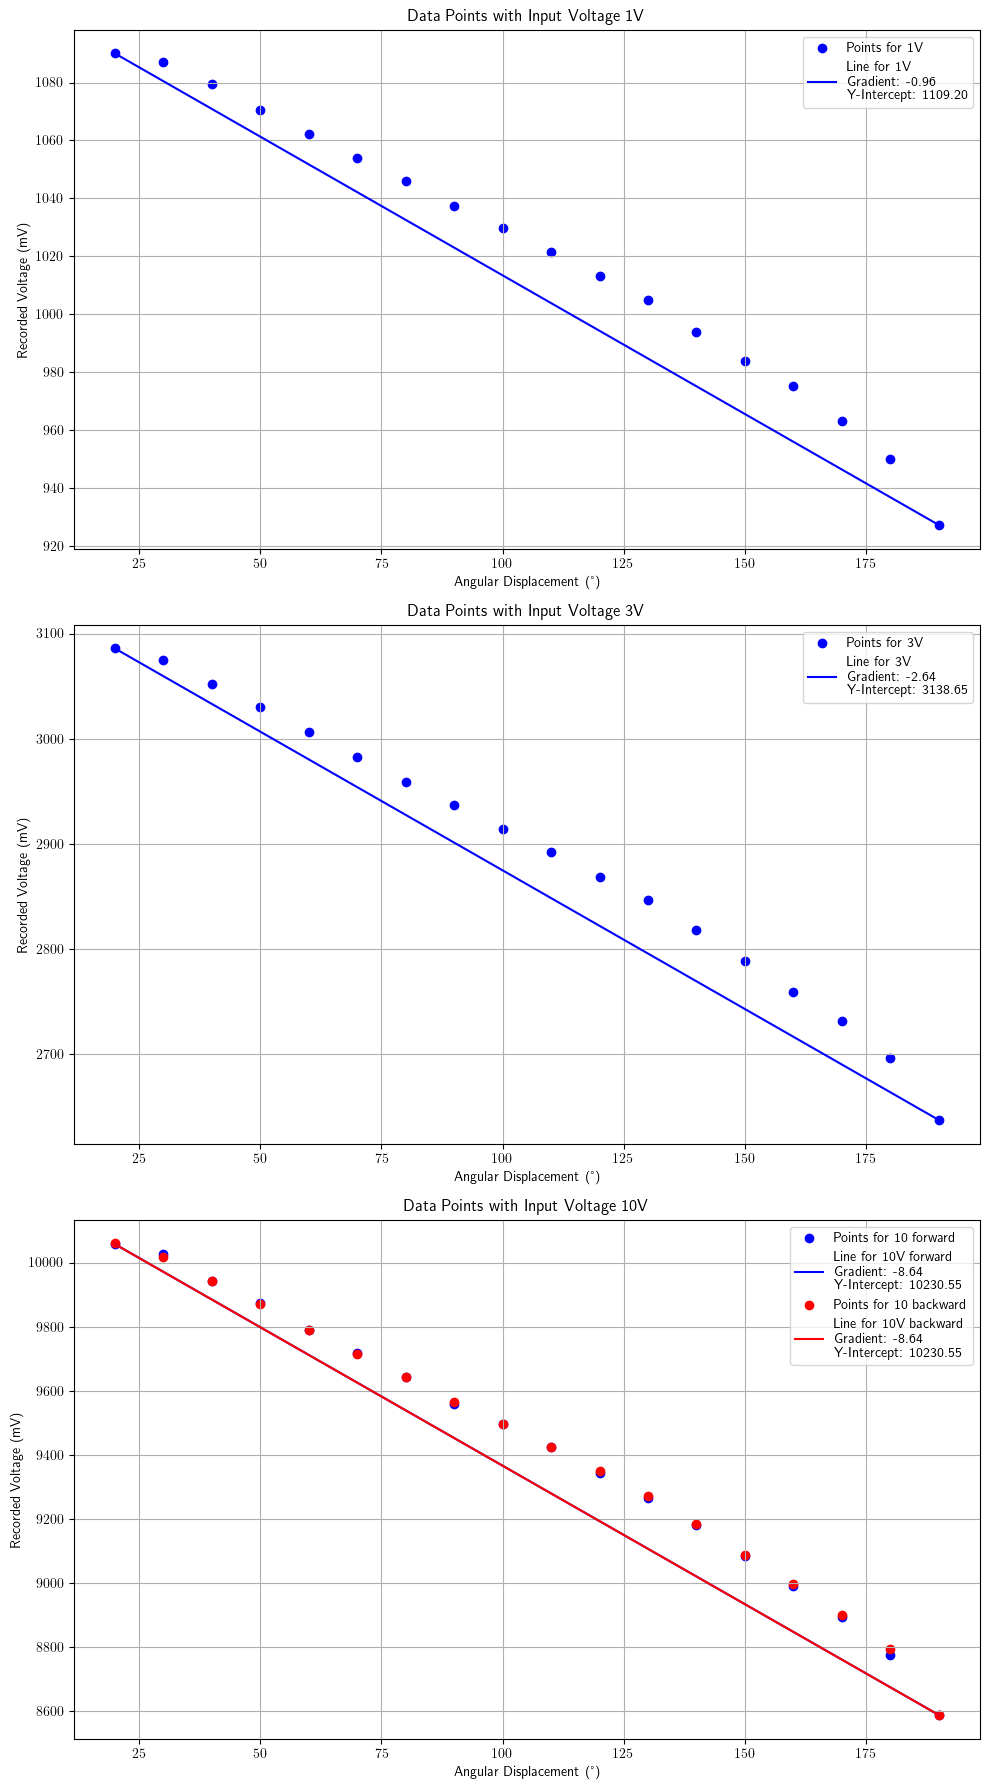

In [175]:
# Filter to only include values between 20-190 degrees
df_list_range1 = [df[(df["Angular Displacement"] >= 20) & (df["Angular Displacement"] <= 190)] for df in df_list]

K_values = []
a_values = []

for df, input_voltage in zip(df_list_range1, input_voltages):
    if input_voltage == 10:
        for set_val in ["forward", "backward"]:
            temp_df = df[df["Set"] == set_val]
            delta_y = temp_df["Recorded Voltage (mV)"].iloc[0] - temp_df["Recorded Voltage (mV)"].iloc[-1]
            delta_x = temp_df["Angular Displacement"].iloc[0] - temp_df["Angular Displacement"].iloc[-1]
            k_val = delta_y / delta_x
            a_val = temp_df["Recorded Voltage (mV)"].iloc[0] - k_val * temp_df["Angular Displacement"].iloc[0]
            K_values.append(k_val)
            a_values.append(a_val)
    else:
        delta_y = df["Recorded Voltage (mV)"].iloc[0] - df["Recorded Voltage (mV)"].iloc[-1]
        delta_x = df["Angular Displacement"].iloc[0] - df["Angular Displacement"].iloc[-1]
        k_val = delta_y / delta_x
        a_val = df["Recorded Voltage (mV)"].iloc[0] - k_val * df["Angular Displacement"].iloc[0]
        K_values.append(k_val)
        a_values.append(a_val)


# Create separate plots for each DataFrame
fig, axes = plt.subplots(len(df_list), 1, figsize=(10, 6 * len(df_list)))
color_map = {
    "forward": "blue",
    "backward": "red"
}

for ax, df, volt, K, a in zip(axes, df_list_range1, input_voltages, K_values, a_values):
    if volt == 10:
        for set_val, color in color_map.items():
            subset = df[df["Set"] == set_val]
            ax.scatter(subset["Angular Displacement"], subset["Recorded Voltage (mV)"], color=color, label=f"Points for {volt} {set_val}")
            
            x_vals = df["Angular Displacement"].values
            y_vals = K * x_vals + a
            ax.plot(x_vals, y_vals, color=color, label=f"Line for {volt}V {set_val}\nGradient: {K:.2f}\nY-Intercept: {a:.2f}")
    else:
        ax.scatter(df["Angular Displacement"], df["Recorded Voltage (mV)"], color="blue", label=f"Points for {volt}V")    
        x_vals = df["Angular Displacement"].values
        y_vals = K * x_vals + a
        ax.plot(x_vals, y_vals, color="blue", label=f"Line for {volt}V\nGradient: {K:.2f}\nY-Intercept: {a:.2f}")


    ax.set_title(f"Data Points with Input Voltage {volt}V")
    ax.set_xlabel("Angular Displacement (\u00B0)")
    ax.set_ylabel("Recorded Voltage (mV)")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [176]:
# Calculating "Non linearity" and adding it as a new column to each DataFrame

for df, k, a, volt in zip(df_list_range1, K_values, a_values, input_voltages):
    # Check if the dataframe has a "Set" column
    df["Non linearity"] = np.nan
    
     # Define a function to compute non-linearity for each row
    def compute_non_linearity(row):
        if volt == 10:
            if row["Set"] == "forward":
                return row["Recorded Voltage (mV)"] - (k * row["Angular Displacement"] + a)
            else:
                return row["Recorded Voltage (mV)"] - (K_values[3] * row["Angular Displacement"] + a_values[3])
        else:
            return row["Recorded Voltage (mV)"] - (k * row["Angular Displacement"] + a)
    
    # Apply the function to each row
    df["Non linearity"] = df.apply(compute_non_linearity, axis=1)
    
    max_val = df["Recorded Voltage (mV)"].max()
    min_val = df["Recorded Voltage (mV)"].min()
    
    df["Percentage Non Linearity"] = (df["Non linearity"] / (max_val-min_val))*100
    
df_list_range1


[    Input Voltage      Set  Angular Displacement  Recorded Voltage (mV)  \
 2               1  forward                    20               1090.046   
 3               1  forward                    30               1087.004   
 4               1  forward                    40               1079.484   
 5               1  forward                    50               1070.348   
 6               1  forward                    60               1062.334   
 7               1  forward                    70               1053.810   
 8               1  forward                    80               1046.057   
 9               1  forward                    90               1037.216   
 10              1  forward                   100               1029.678   
 11              1  forward                   110               1021.626   
 12              1  forward                   120               1013.229   
 13              1  forward                   130               1005.055   
 14         

We can then find the max non-linearity for each section

In [177]:
for df, input_voltage in zip(df_list_range1, input_voltages):
    if input_voltage == 10:
        for set_val in sets:
            temp_df = df[df["Set"]==set_val]
            print(f"Max Non-Linearity at {input_voltage}V {set_val} is {temp_df['Percentage Non Linearity'].max():.2f}%")
    else:
        print(f"Max Non-Linearity at {input_voltage}V is {df['Percentage Non Linearity'].max():.2f}%")

Max Non-Linearity at 1V is 12.50%
Max Non-Linearity at 3V is 11.34%
Max Non-Linearity at 10V forward is 10.86%
Max Non-Linearity at 10V backward is 11.11%


Now let us find the hysteresis